In [20]:
import datetime
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
# import pandas_datareader 
import pprint
import statsmodels.tsa.stattools as ts
import statsmodels.api as sm

import requests

from datetime import datetime,timedelta

# Input apikey
apikey=""
UA = '' 



In [155]:
def return_close_price(df):
    return(df['close'])

In [159]:
def plot_price_series(df, ts1, ts2):
    months = mdates.MonthLocator() # every month
    fig, ax = plt.subplots()
    ax.plot(df.index, df[ts1], label=ts1)
    ax.plot(df.index, df[ts2], label=ts2)
#     ax.xaxis.set_major_locator(months)
#     ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
#     ax.set_xlim(datetime.datetime(2012, 1, 1), datetime.datetime(2013, 1, 1))
    ax.grid(True)
    fig.autofmt_xdate()
    plt.xlabel('Month/Year')
    plt.ylabel('Price ($)')
    plt.title('%s and %s Daily Prices' % (ts1, ts2))
    plt.legend()
    plt.show()

In [160]:
def plot_scatter_series(df, ts1, ts2):
    plt.xlabel('%s Price ($)' % ts1)
    plt.ylabel('%s Price ($)' % ts2)
    plt.title('%s and %s Price Scatterplot' % (ts1, ts2))
    plt.scatter(df[ts1], df[ts2])
    plt.show()

In [216]:
def plot_residuals(df_index,res):
    months = mdates.MonthLocator() # every month
    fig, ax = plt.subplots()
    ax.plot(df_index, res, label="Residuals")
#     ax.xaxis.set_major_locator(months)
#     ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
#     ax.set_xlim(datetime.datetime(2012, 1, 1), datetime.datetime(2013, 1, 1))
    ax.grid(True)
    fig.autofmt_xdate()
    plt.xlabel('Month/Year')
    plt.ylabel('Price ($)')
    plt.title('Residual Plot')
    plt.legend()
    plt.plot(res)
    plt.show()

In [123]:
def fetch_candles(market,period,periodqty):
    url = "https://www.cldxio.com/subs?do=getcandles&periodqty="+periodqty+"&period="+period+"&channel="+market+"&key="+apikey
    r = requests.get(url, headers={'User-Agent': UA})
    data = r.json()
    
    Open = []
    High = []
    Low = []
    Close = []
    Volume = []
    Timestamp = []

    for d in data['result'][market]:
        Open.append(d['o'])
        High.append(d['h'])
        Low.append(d['l'])
        Close.append(d['c'])
        Volume.append(d['v'])
        Timestamp.append(d['t'])

    newtimestamp = list()
    for val in Timestamp:
        val1= val.split('.')
        datetime_object = datetime.strptime(val1[0], '%Y-%m-%d %H:%M:%S')
        datetime_object += timedelta(hours=8)
        
        newtimestamp.append(datetime_object)
    
    m0s0timestamp = list()
    
    for val in newtimestamp:
        m0s0timestamp.append(val.replace(minute = 0,second = 0))
        
    temp_df = pd.DataFrame(index = m0s0timestamp, columns=['close','high','low','open','volume','timestamp'])
    temp_df['close'] = Close
    temp_df['high'] = High
    temp_df['low'] = Low
    temp_df['open'] = Open
    temp_df['volume'] = Volume
    temp_df['timestamp'] = newtimestamp
#     temp_df['m0s0timestamp'] = m0s0timestamp
    
    return(temp_df)

In [124]:
xmr_usd = fetch_candles('USDT-XMR','1H','1460')

In [168]:
# all bittrex usd pairs
# note the syntax of pairs with limiter '/', the api from clue dex uses the reverse and with limiter '-'
btrx_usd = ['ADA/USDT','BCH/USDT','BTC/USDT','BTG/USDT','DASH/USDT','ETC/USDT','ETH/USDT','LTC/USDT','NEO/USDT',
 'NXT/USDT','OMG/USDT','TUSD/USDT','XMR/USDT','XRP/USDT','XVG/USDT','ZEC/USDT']

In [166]:
def create_closepricedf(btrx_list):
    dataframe = pd.DataFrame()
    rbtrx_list = list()
    for val in btrx_list:
        val1 = val.split('/')
        rbtrx_list.append(val1[1] + '-' + val1[0])
        
    for index,val in enumerate(rbtrx_list):
        try:
            dataframe[btrx_list[index]]= fetch_candles(val,'1H','1460')['close']
        except TypeError:
            print(val +' has a problem')
            
    dataframe = dataframe.fillna(method='ffill')
    
    return(dataframe)

In [170]:
btrx_close = create_closepricedf(btrx_usd)

USDT-BCHhas a problem


In [227]:
# using stat models to find residuals with ordinary least squares
res = sm.OLS(btrx_close['NEO/USDT'], btrx_close['ETC/USDT'])
# beta_hr = res.beta.x
results = res.fit()

In [228]:
# parameter
results.params

ETC/USDT    2.110811
dtype: float64

In [229]:
res_list = btrx_close['NEO/USDT'] -  2.110811 * btrx_close['ETC/USDT']

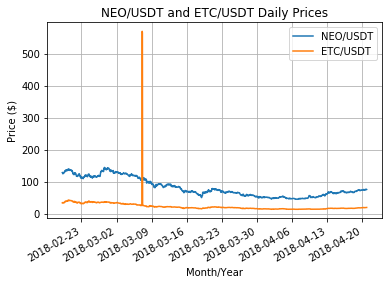

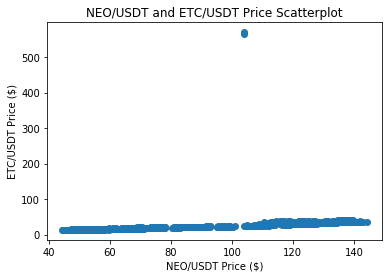

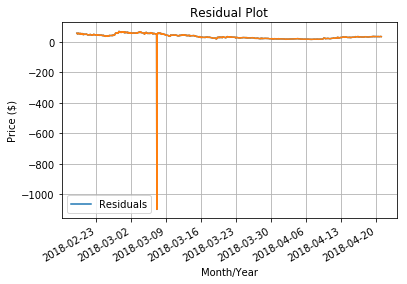

(-5.4630757559787755,
 2.493439660634365e-06,
 24,
 1435,
 {'1%': -3.4349151819757466,
  '10%': -2.5678434198545568,
  '5%': -2.8635562160047781},
 13994.130675617169)


In [230]:
# See Prices of Pairs 
plot_price_series(btrx_close,'NEO/USDT','ETC/USDT')
plot_scatter_series(btrx_close,'NEO/USDT','ETC/USDT')
# Plotting Residuals
plot_residuals(btrx_close.index,res_list)
# Now the augmenteddickeyfuller accepts a residual array
cadf = ts.adfuller(res_list)
# Inspect significance value with alpha = 0.05 or at 5% level
# if the p value at that level is less than 0.05 then it rejects the null hypothesis that there
# -isn't a cointegrating relationship between the two cryptocurrency pairs 
pprint.pprint(cadf)

In [203]:
btrx_close

,ADA/USDT,BTC/USDT,BTG/USDT,DASH/USDT,ETC/USDT,ETH/USDT,LTC/USDT,NEO/USDT,NXT/USDT,OMG/USDT,...,XMR/USDT,XRP/USDT,XVG/USDT,ZEC/USDT,res.DASH.XMR,res.ZEC.XMR,res.XVG.XMR,res.XVG.ZEC,res.XVG.DASH,res.ZEC.DASH
2018-02-19 04:00:00,0.372500,10711.000000,134.000000,711.877830,33.250000,930.850000,218.000000,128.000000,0.252899,16.790000,...,307.748000,1.096302,0.076878,458.643200,125.658513,91.721107,0.007634,-0.008430,-0.006412,15.021581
2018-02-19 05:00:00,0.374000,10739.390000,133.599999,703.175998,33.900000,927.140000,217.300000,127.000000,0.248800,16.941040,...,297.000000,1.107420,0.075512,0.075512,137.430202,-354.031945,0.008687,0.075498,-0.006759,-438.123378
2018-02-19 06:00:00,0.376000,10521.000000,132.220910,694.817391,34.080000,915.377500,215.219990,126.083201,0.251100,16.600000,...,299.770746,1.080451,0.076500,455.534400,123.793689,98.123435,0.009052,-0.008229,-0.004794,22.544351
2018-02-19 07:00:00,0.360031,10380.000000,127.500000,681.066593,34.376183,906.010000,213.100000,124.225000,0.246300,16.429991,...,297.185945,1.064500,0.075008,447.000000,114.966595,92.670844,0.008141,-0.008134,-0.004677,22.579050
2018-02-19 08:00:00,0.366100,10365.999618,130.000000,688.438329,33.900000,919.000000,217.630000,126.238223,0.245700,16.160000,...,295.000000,1.083000,0.077000,447.750000,126.502269,96.027105,0.010625,-0.006281,-0.003547,18.735198
2018-02-19 09:00:00,0.371744,10629.433646,132.320076,696.673000,34.313948,920.365050,217.900000,128.270000,0.247456,16.430000,...,300.200000,1.100000,0.082000,471.334024,124.831626,113.411268,0.014455,-0.005668,0.000489,37.187614
2018-02-19 10:00:00,0.369046,10574.990000,131.340000,690.701971,33.400640,921.200000,217.737110,127.259400,0.249771,16.330046,...,296.917732,1.090000,0.081641,469.987000,125.112885,115.977629,0.014835,-0.005776,0.000829,39.561562
2018-02-19 11:00:00,0.368001,10561.100000,131.333400,706.303158,33.611000,926.978653,216.899999,126.156000,0.245819,16.395392,...,300.593000,1.084050,0.080000,458.880869,133.713172,100.489546,0.012367,-0.005352,-0.002637,18.733223
2018-02-19 12:00:00,0.369000,10534.000000,130.511000,689.250411,33.800000,929.610000,216.500000,127.305000,0.245819,16.849971,...,301.245000,1.089000,0.080000,453.391650,115.418450,94.222960,0.012220,-0.004331,-0.000642,23.870782
2018-02-19 13:00:00,0.365101,10458.050000,130.000000,691.852050,33.523451,925.000000,215.999990,127.573302,0.240541,16.800000,...,298.000000,1.079797,0.078200,454.681500,124.201386,99.381762,0.011150,-0.006371,-0.002747,23.539366


In [235]:
xmr_usd

,close,high,low,open,volume,timestamp
2018-02-19 04:00:00,307.748000,307.902000,305.250000,306.000000,18285.525452,2018-02-19 04:06:36
2018-02-19 05:00:00,297.000000,304.000000,295.000000,303.259503,140063.970799,2018-02-19 05:03:19
2018-02-19 06:00:00,299.770746,302.775948,298.735360,302.000000,3617.942290,2018-02-19 06:03:12
2018-02-19 07:00:00,297.185945,299.660000,292.490020,298.279350,80777.800181,2018-02-19 07:01:26
2018-02-19 08:00:00,295.000000,295.000000,287.848037,292.490020,104501.566493,2018-02-19 08:01:33
2018-02-19 09:00:00,300.200000,300.200000,291.309868,291.309868,598.349441,2018-02-19 09:03:10
2018-02-19 10:00:00,296.917732,301.396000,296.917732,298.433215,8671.817096,2018-02-19 10:11:47
2018-02-19 11:00:00,300.593000,301.475578,295.136231,296.917732,163086.144485,2018-02-19 11:09:17
2018-02-19 12:00:00,301.245000,301.500000,299.274110,300.593000,9457.867958,2018-02-19 12:00:34
2018-02-19 13:00:00,298.000000,301.244522,298.000000,301.244522,55134.780541,2018-02-19 13:16:11
